В рамках данного проекта мы будем анализировать длительность поездки на такси в Нью-Йорке на основании датасета из [соревнования Kaggle](https://www.kaggle.com/competitions/nyc-taxi-trip-duration).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

In [2]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')

In [3]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Колонка dropoff_datetime отсутствует в тестовой выборке из соревнования, поэтому мы не будем её использовать.

In [4]:
df.drop(['dropoff_datetime'], axis = 1, inplace = True)

In [5]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

В соревновании использовалась метрика качества RMSLE, поэтому мы также будем её использовать. Для этого мы можем предсказывать логарифм таргета и затем пользоваться RMSE.

In [6]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])
df.drop(['trip_duration'], axis = 1, inplace = True)

Рассмотрим распределение логарифма таргета trip_duration. Для этого построим гистограмму.

(array([3.30000e+01, 0.00000e+00, 1.77000e+02, 0.00000e+00, 3.18000e+02,
        0.00000e+00, 3.17000e+02, 2.84000e+02, 1.92000e+02, 2.18000e+02,
        2.06000e+02, 4.21000e+02, 1.64000e+02, 3.14000e+02, 4.50000e+02,
        2.77000e+02, 5.24000e+02, 4.02000e+02, 4.85000e+02, 6.11000e+02,
        5.53000e+02, 8.32000e+02, 9.16000e+02, 1.43000e+03, 1.69300e+03,
        2.84800e+03, 4.24500e+03, 6.00800e+03, 8.77800e+03, 1.29630e+04,
        1.89590e+04, 2.64870e+04, 3.55110e+04, 4.50130e+04, 5.88140e+04,
        6.89740e+04, 8.24950e+04, 9.34350e+04, 1.03080e+05, 1.11102e+05,
        1.12725e+05, 1.12528e+05, 1.07650e+05, 9.74220e+04, 8.52740e+04,
        7.07090e+04, 5.56630e+04, 4.15460e+04, 2.92120e+04, 2.03730e+04,
        1.39830e+04, 8.88500e+03, 5.48400e+03, 3.14100e+03, 1.47600e+03,
        5.90000e+02, 2.03000e+02, 8.50000e+01, 3.80000e+01, 2.00000e+01,
        2.00000e+01, 1.10000e+01, 4.00000e+00, 5.00000e+00, 1.10000e+01,
        1.20000e+01, 1.70000e+01, 1.50000e+01, 1.70

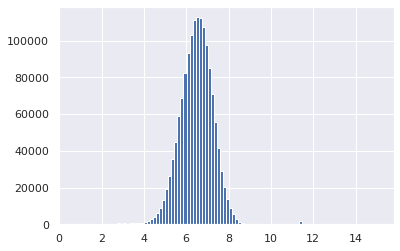

In [7]:
plt.hist(df.log_trip_duration, bins=100)

Для начала, чтобы иметь некоторую стартовую точку, рассмотрим значение метрики при наилучшей константе. Для RMSE это будет среднее значение таргета.

In [8]:
from sklearn.metrics import mean_squared_error
best_constant = df.log_trip_duration.mean()
constant_array = np.zeros(df.shape[0])
constant_array.fill(best_constant)
mean_squared_error(df['log_trip_duration'], constant_array, squared = False)

0.7957592365411509

##Первая модель##

Теперь посмотроим графии зависимости количества поездок от месяца, дня недели и часа, а также сгруппируем наши данные по датам. 

In [9]:
df['pickup_date'] = df['pickup_datetime'].dt.day.astype('str') +"-"+ df['pickup_datetime'].dt.month.astype('str')
df['pickup_month'] = df['pickup_datetime'].dt.month.astype('str')
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
grouped_by_day = df.groupby('day_of_week').count().reset_index()
grouped_by_hour = df.groupby('hour').count().reset_index()

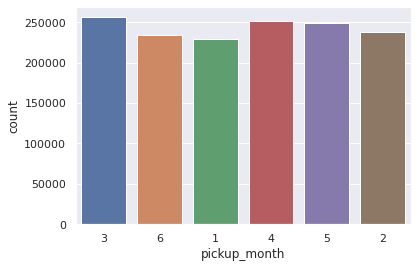

In [10]:
sns.countplot(x ='pickup_month', data = df)
plt.show()

In [11]:
grouped = df.groupby('pickup_date').count().reset_index()
grouped.sort_values('id', ascending=True)

,pickup_date,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,pickup_month,day_of_week,hour,day
90,23-1,1648,1648,1648,1648,1648,1648,1648,1648,1648,1648,1648,1648,1648,1648
96,24-1,3383,3383,3383,3383,3383,3383,3383,3383,3383,3383,3383,3383,3383,3383
141,30-5,5570,5570,5570,5570,5570,5570,5570,5570,5570,5570,5570,5570,5570,5570
102,25-1,6084,6084,6084,6084,6084,6084,6084,6084,6084,6084,6084,6084,6084,6084
132,3-1,6353,6353,6353,6353,6353,6353,6353,6353,6353,6353,6353,6353,6353,6353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,13-2,9309,9309,9309,9309,9309,9309,9309,9309,9309,9309,9309,9309,9309,9309
69,2-4,9325,9325,9325,9325,9325,9325,9325,9325,9325,9325,9325,9325,9325,9325
154,5-3,9597,9597,9597,9597,9597,9597,9597,9597,9597,9597,9597,9597,9597,9597
45,16-4,9602,9602,9602,9602,9602,9602,9602,9602,9602,9602,9602,9602,9602,9602


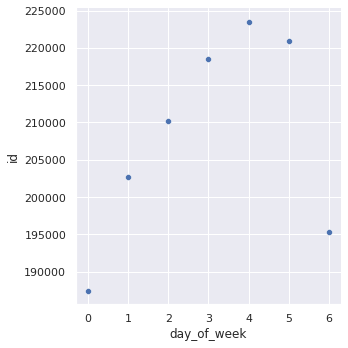

In [12]:
sns.relplot(data = grouped_by_day, x = 'day_of_week', y = 'id')

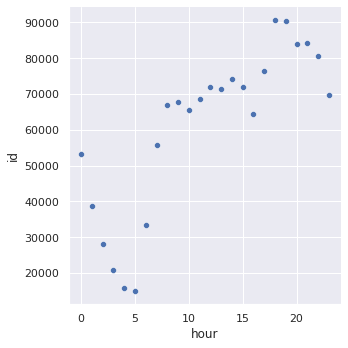

In [13]:
sns.relplot(data = grouped_by_hour, x = 'hour', y = 'id')

Мы уже можем заметить, что 23 и 24 январе было аномально мало поездок. Вероятно, это связано с метелью 23 и 24 января 2016 года в США.

Теперь изобразим на одном графике зависимости количества поездок от часа в сутках для разных месяцев, аналогично поступим для разных дней недели.

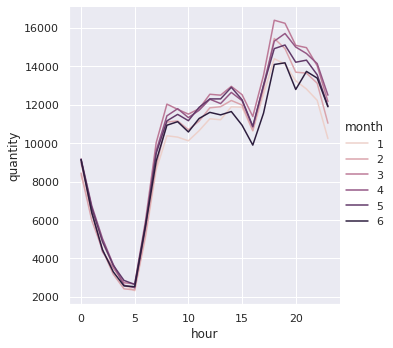

In [14]:
df['month'] = df['pickup_datetime'].dt.month
grouped_hour_month = df.groupby(['hour', 'month'])['id'].agg('count').reset_index(name='quantity')
sns.relplot(data = grouped_hour_month, x = 'hour', y = 'quantity', hue ='month', kind="line")

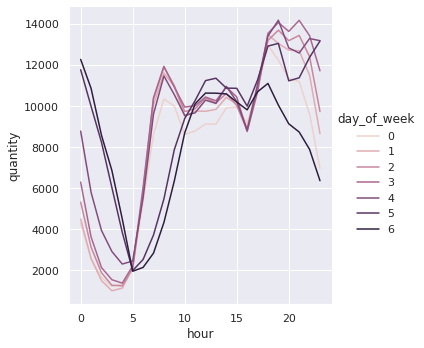

In [15]:
grouped_hour_day = df.groupby(['hour', 'day_of_week'])['id'].agg('count').reset_index(name='quantity')
sns.relplot(data = grouped_hour_day, x = 'hour', hue ='day_of_week', y = 'quantity', kind="line")

Исходя из графиков выше, мы можем сказать, что в среднем происходит спад количества поездок, начиная с 8 часов вечера и заканчивая 5 часами утра. Затем количество поездок снова начинает расти. Это вполне объяснимо: ночью количество людей, которым требуется такси, явно меньше. <br>
Однако, нужно отметить, что имеется отличие для воскресенья: в этот день спад начинается раньше, а именно около 17 часов. 

Построим график зависимости среднего логарифма времени поездки от дня недели, также построим такие же графики для часа в сутках и дня в году.

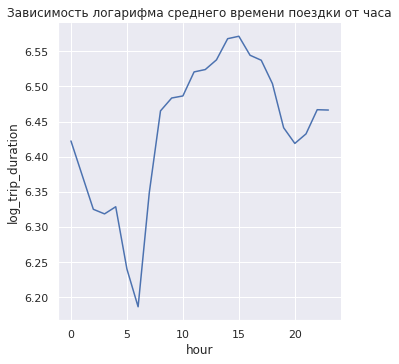

In [16]:
df_hour = pd.DataFrame(df.groupby(['hour']).log_trip_duration.mean())
plot = sns.relplot(data = df_hour, x = 'hour', y = 'log_trip_duration', kind='line')
plot.set(title='Зависимость логарифма среднего времени поездки от часа')

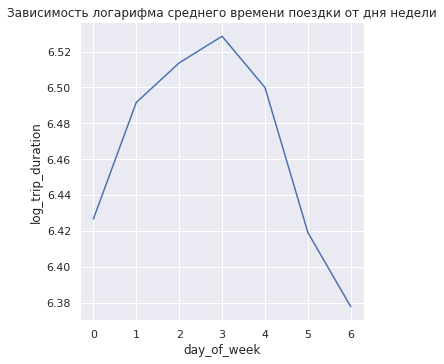

In [17]:
df_day_of_week = pd.DataFrame(df.groupby(['day_of_week']).log_trip_duration.mean())
plot_2 = sns.relplot(data = df_day_of_week, x = 'day_of_week', y = 'log_trip_duration', kind='line')
plot_2.set(title='Зависимость логарифма среднего времени поездки от дня недели')

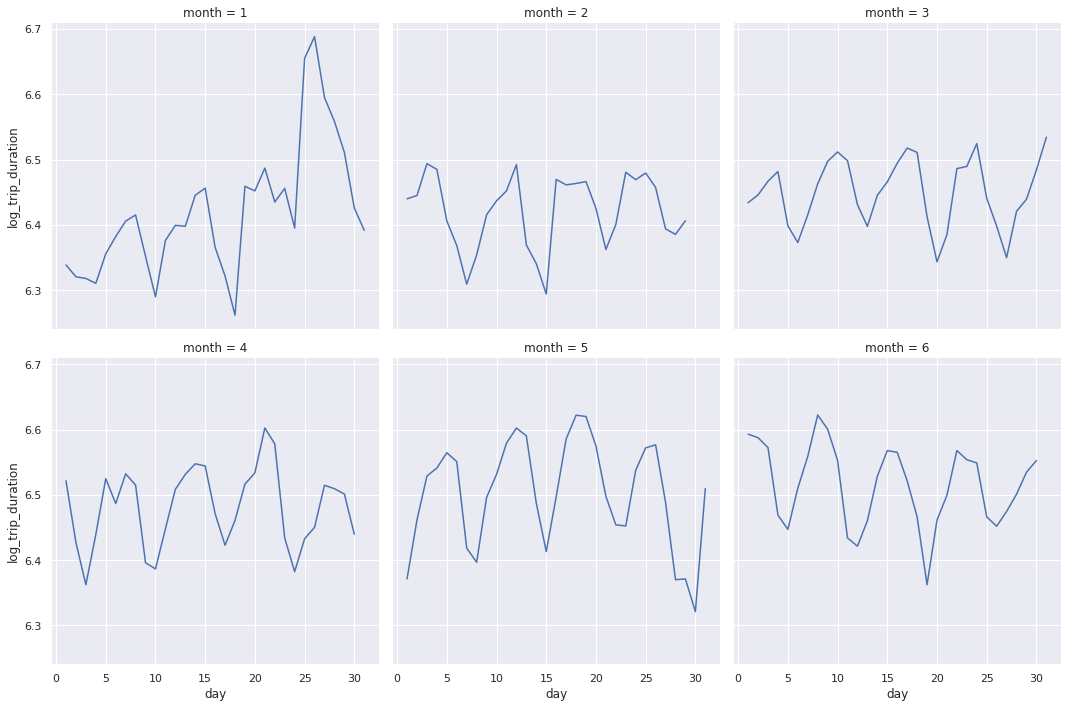

In [18]:
df_date_grouped = pd.DataFrame(df.groupby(['month', 'day']).log_trip_duration.mean())
df_date_grouped.reset_index(level=['month','day'], inplace=True)
grid_date = sns.FacetGrid(df_date_grouped, col='month', col_wrap=3, height=5)
grid_date.map(sns.lineplot, 'day', 'log_trip_duration')

Исходя из графика выше, можем отметить, что концу недели соответствует меньшая продолжительность поездки, что также отражается на "периодичности" графиков для дней в году. Отметитим, что исключительная ситуация, а именно метель, отражена также в увеличении среднего времени поездки 23-24 января. 

Обработаем аномальный период, выделив бинарный признак, показывающий относится ли данная поездка к этому периоду или нет.

In [19]:
df['day_of_year'] = df['pickup_datetime'].dt.day_of_year
df['is_anomaly']=(df['month'] == 1) & ((df['pickup_datetime'].dt.day == 23) | (df['pickup_datetime'].dt.day == 24))

Приступим к обучению первой модели, в качестве модели выберем линейную регрессию с Ridge регуляризацией. <br> 
Для начала воспользуемся следующими признаками: <br>
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным
5. Номер дня в году

In [20]:
categorical = ['day_of_week', 'month', 'hour', 'is_anomaly', 'day']

In [21]:
from sklearn.model_selection import train_test_split


X = df[categorical]
y = df['log_trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [22]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

In [23]:
column_trans = make_column_transformer(
(OneHotEncoder(), categorical),
remainder='passthrough')
model = Ridge()

In [24]:
pipe = make_pipeline(column_trans, model)
pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)
print("Train RMSE:", mean_squared_error(y_train, y_train_pred, squared = False))
print("Test RMSE:", mean_squared_error(y_test, y_test_pred, squared = False))

Train RMSE: 0.7894119227501143
Test RMSE: 0.7874666287791634


Как можно заметить, пока что значение метрики качество пока что лишь незначительно лучше такового для лучшего константного предсказания. Продолжаем улучшать модель.

##Вторая модель##

Для построения следующей модели начнём изучение координат. Для начала отобразим на карте точки начала и конца поездки. 

In [25]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import folium

In [27]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [28]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

Как можно заметить, особенно выделяется Манхэттен, что неудивительно, поскольку он является одним из наиболее оживлённых мест Нью-Йорка. Также отметитим ещё два скопления точек: аэропорты JFK и LaGuardia. 

Помимо координат, нам может очень помочь в улучшении модели признак, отражающий расстояние которое необходимо было преодавлеть такси. Точно его посчитать не представляется возможным, но мы можем это сделать посредством подсчёта расстояния между точками начала и конца поездки.

In [29]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [30]:
df['haversine'] = haversine_array(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)

Поскольку мы предсказываем лографим от времени поездки, имеет смысл логарифмировать расстояние, чтобы добиться линейной зависимости целевой переменной от признака.

In [31]:
df['haversine_log'] = np.log1p(df['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с таргетом, чем просто расстояние:

[Text(0.5, 1.0, 'Коэффициент корреляции для расстояния и его логарифма')]

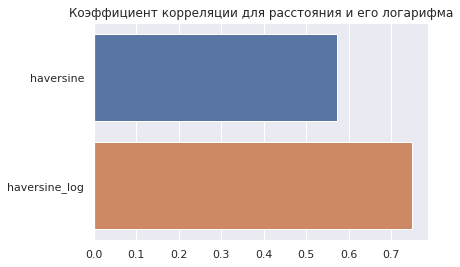

In [32]:
corr = df[['haversine', 'haversine_log']].corrwith(df['log_trip_duration'])
sns.barplot(x=corr.values, y=corr.index).set(title='Коэффициент корреляции для расстояния и его логарифма')

Изучим среднюю скорость движения такси. Для этого для каждого объекта обучающей выборки рассчитаем её, разделив haversine на trip_duration и нарисуем гистограмму её распределения.

[Text(0.5, 1.0, 'Гистограмма распределения средней скорости такси')]

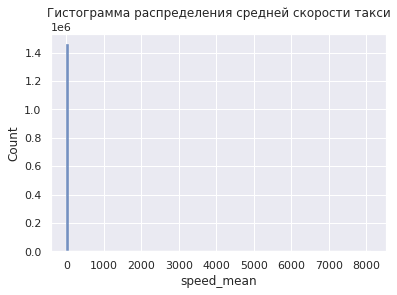

In [33]:
df['speed_mean'] = df['haversine']/(np.exp(df['log_trip_duration'].values) / 3600)
sns.histplot(data = df, x='speed_mean', bins = 100).set(title = 'Гистограмма распределения средней скорости такси')

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень большие значения скоростей. Нарисуем гистограмму по объектам, для которых значение скоростей, является разумным.

(array([10882.,  1810.,  1366.,  1484.,  1851.,  2445.,  3523.,  4733.,
         6408.,  8384., 10803., 13359., 16300., 18890., 21656., 24684.,
        27592., 29938., 32958., 34611., 36596., 38148., 39708., 40507.,
        41048., 41239., 41715., 41139., 40986., 39650., 38866., 37813.,
        36082., 35219., 34171., 32384., 30812., 29488., 27871., 26660.,
        25429., 24147., 22921., 21310., 20232., 19014., 18132., 16843.,
        16184., 15200., 14440., 13601., 12701., 11911., 11382., 10634.,
         9916.,  9448.,  8847.,  8362.,  7906.,  7411.,  7018.,  6617.,
         6235.,  5850.,  5734.,  5359.,  4927.,  4598.,  4334.,  4196.,
         3947.,  3753.,  3643.,  3265.,  3109.,  2984.,  2878.,  2720.,
         2649.,  2384.,  2326.,  2202.,  2071.,  2007.,  1896.,  1709.,
         1688.,  1671.,  1550.,  1497.,  1426.,  1327.,  1256.,  1240.,
         1157.,  1116.,  1012.,   956.]),
 array([ 0.        ,  0.40625511,  0.81251021,  1.21876532,  1.62502043,
         2.03127553, 

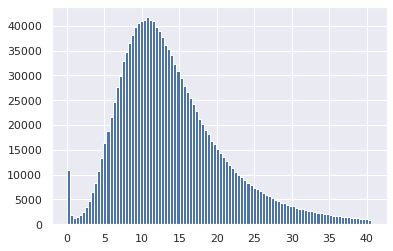

In [34]:
plt.hist(df['speed_mean'], bins = 100, range=(0, np.percentile(df['speed_mean'], 99)))

<Axes: xlabel='hour', ylabel='day_of_week'>

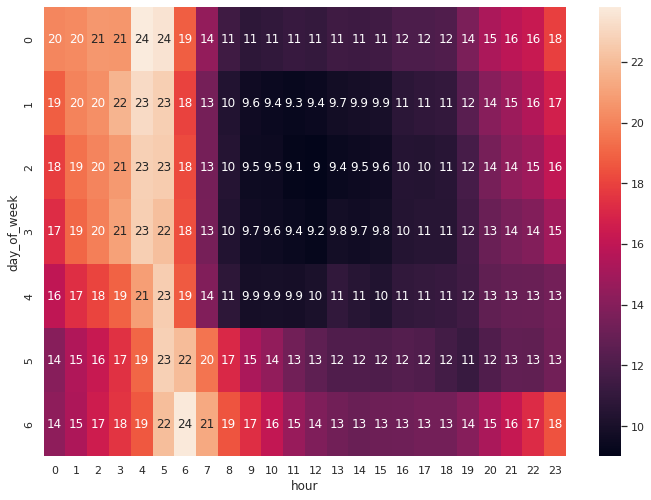

In [35]:
speed_median = df.groupby(['day_of_week', 'hour'])['speed_mean'].median()
speed_median = speed_median.reset_index()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(speed_median.pivot(index='day_of_week', columns='hour', values='speed_mean'), annot = True) 

Скорость нам понадобится в будущем, но мы не можем использовать её в качестве признака, поскольку мы не сможем её однозначно определить для новых данных. 

In [36]:
df.drop('speed_mean', axis=1, inplace=True)

Добавим бинарный признак "поездка соверщается в период пробки", выделив периоды, в которые скорость поездок была минимальной.

In [37]:
df['jam'] = df['day_of_week'].between(1, 4, inclusive='both') & df['hour'].between(8, 18, inclusive='both')

Теперь для каждого объекта добавим 4 новых бинарных признака:
- поездка началась/закончилась в аэропорту JFK
- поездка началась/закончилась в аэропорту LaGuardia

In [38]:
df['is_la_guardia_pickup'] = \
((df['pickup_longitude'] >= -73.877283) & \
(df['pickup_longitude'] <= -73.855907) & \
(df['pickup_latitude'] >= 40.767230) & \
(df['pickup_latitude'] <= 40.778117)) * 1

df['is_la_guardia_pickup'] = \
((df['pickup_longitude'] >= -73.877283) & \
(df['pickup_longitude'] <= -73.855907) & \
(df['pickup_latitude'] >= 40.767230) & \
(df['pickup_latitude'] <= 40.778117)) * 1

In [39]:
df['is_la_guardia_dropoff'] = \
((df['dropoff_longitude'] >= -73.877283) & \
(df['dropoff_longitude'] <= -73.855907) & \
(df['dropoff_latitude'] >= 40.767230) & \
(df['dropoff_latitude'] <= 40.778117)) * 1

df['is_la_guardia_dropoff'] = \
((df['dropoff_longitude'] >= -73.877283) & \
(df['dropoff_longitude'] <= -73.855907) & \
(df['dropoff_latitude'] >= 40.767230) & \
(df['dropoff_latitude'] <= 40.778117)) * 1

In [40]:
df['is_jfk_pickup'] = \
((df['pickup_longitude'] >= -73.811788) & \
(df['pickup_longitude'] <= -73.763278) & \
(df['pickup_latitude'] >= 40.630109) & \
(df['pickup_latitude'] <= 40.662983)) * 1

df['is_jfk_pickup'] = \
((df['pickup_longitude'] >= -73.811788) & \
(df['pickup_longitude'] <= -73.763278) & \
(df['pickup_latitude'] >= 40.630109) & \
(df['pickup_latitude'] <= 40.662983)) * 1

df['is_jfk_dropoff'] = \
((df['dropoff_longitude'] >= -73.811788) & \
(df['dropoff_longitude'] <= -73.763278) & \
(df['dropoff_latitude'] >= 40.630109) & \
(df['dropoff_latitude'] <= 40.662983)) * 1

df['is_jfk_dropoff'] = \
((df['dropoff_longitude'] >= -73.811788) & \
(df['dropoff_longitude'] <= -73.763278) & \
(df['dropoff_latitude'] >= 40.630109) & \
(df['dropoff_latitude'] <= 40.662983)) * 1

Для каждого из новых признаков нарисуем Boxplot распределения логарифма времени поездки.

<Axes: xlabel='is_jfk_pickup', ylabel='log_trip_duration'>

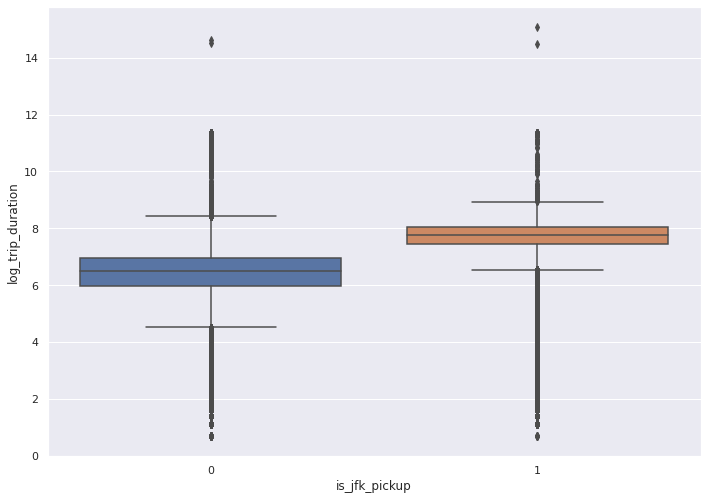

In [41]:
sns.boxplot(data = df, x = 'is_jfk_pickup', y = 'log_trip_duration')

<Axes: xlabel='is_jfk_dropoff', ylabel='log_trip_duration'>

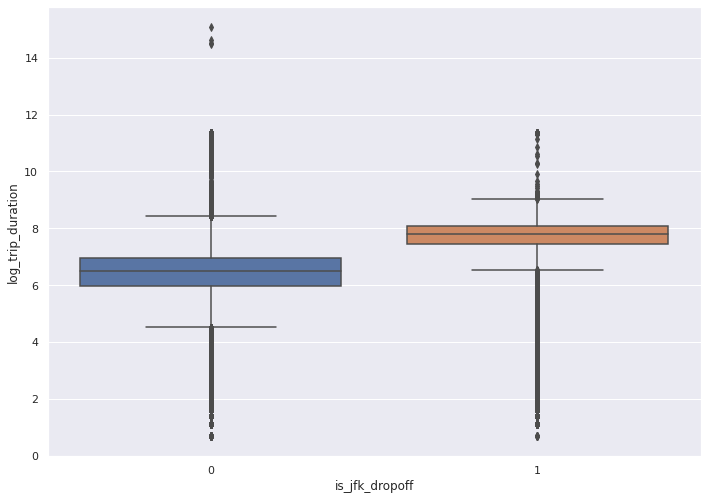

In [42]:
sns.boxplot(data = df, x = 'is_jfk_dropoff', y = 'log_trip_duration')

<Axes: xlabel='is_la_guardia_pickup', ylabel='log_trip_duration'>

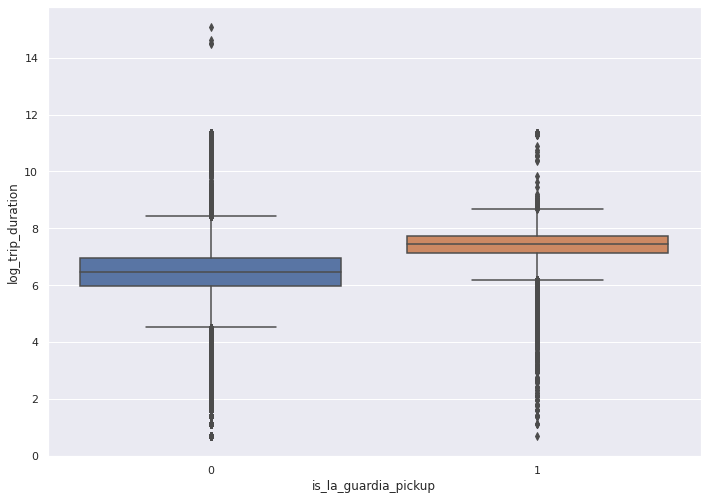

In [43]:
sns.boxplot(data = df, x = 'is_la_guardia_pickup', y = 'log_trip_duration')

<Axes: xlabel='is_la_guardia_dropoff', ylabel='log_trip_duration'>

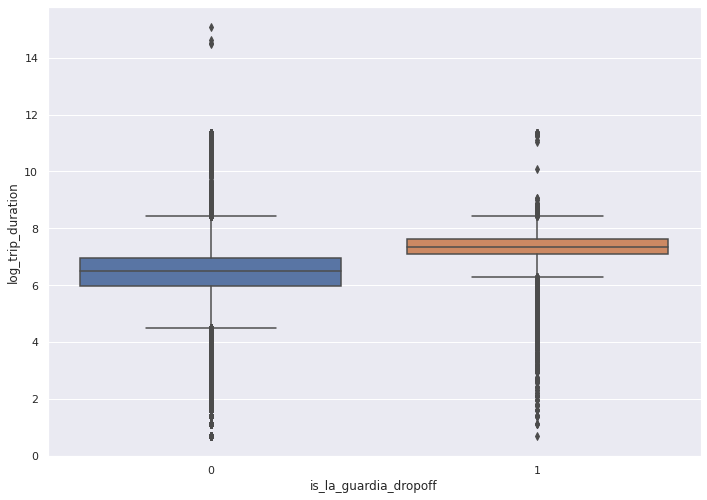

In [44]:
sns.boxplot(data = df, x = 'is_la_guardia_dropoff', y = 'log_trip_duration')

Судя по графика, мы можем заключить, что признаки получились хорошими. Получилось, что в среднем если поездка начинается/заканчивается в аэропорту JFK или LaGuardia, то она длится дольше.

Пока что при построении модели не были задействованы координаты. Обратим внимание, что широту и долготу рассматривать по отдельности не имеет смысла. Для того, чтобы объединить их, разобъём область, где было совершено наибольшее количество поездок, на несколько областей и введём соответствующий признак.

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently
    
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X=None, y=None):
        return self

    def transform(self, X, y=None):
        X_new = X.copy()
        X_new['coordinates_square_num_pickup'] = -1
        X_new['coordinates_square_num_dropoff'] = -1
        count = 1
        p_lat = 40.802
        p_long = -74.02
        p_long_end = -74.01
        p_lat_end = 40.48
        range_first = 10
        range_second = 10
        lat_incr = abs((p_lat - p_lat_end)) / range_first
        long_incr = abs((p_long - p_long_end)) / range_second
        #longitude
        for i in range (0, range_first):
            #latitude
            for j in range (0, range_second):
                X_new.loc[((X_new['pickup_longitude'] >= p_long + long_incr * i) & \
                          (X_new['pickup_longitude'] <= p_long + long_incr * (i+1)) & \
                           (X_new['pickup_latitude'] >= p_lat + lat_incr * j) & \
                           (X_new['pickup_latitude'] <= p_lat + lat_incr * (j+1))), 'coordinates_square_num_pickup'] = count
                X_new.loc[((X_new['dropoff_longitude'] >= p_long + long_incr * i) & \
                          (X_new['dropoff_longitude'] <= p_long + long_incr * (i+1)) & \
                           (X_new['dropoff_latitude'] >= p_lat + lat_incr * j) & \
                           (X_new['dropoff_latitude'] <= p_lat + lat_incr * (j+1))), 'coordinates_square_num_dropoff'] = count
                count += 1
        return X_new

In [46]:
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

Обучим модель, используя новые признаки.

In [47]:
categorical = ['coordinates_square_num_pickup', 'coordinates_square_num_dropoff', 'day_of_week', 'hour', 'month', \
               'day_of_year', 'is_la_guardia_pickup', 'is_la_guardia_dropoff', 'is_jfk_pickup', \
       'is_jfk_dropoff']
X = df.drop(['log_trip_duration'], axis = 1)
y = df.log_trip_duration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
column_trans = make_column_transformer(
(OneHotEncoder(handle_unknown="ignore"), categorical),
remainder='passthrough')
model = Ridge()
mapTransformer = MapGridTransformer()
dropTransformer = columnDropperTransformer(['id', 'vendor_id', 'pickup_datetime', 'passenger_count', \
       'pickup_longitude', 'pickup_latitude', 'haversine', 'dropoff_longitude', \
       'dropoff_latitude', 'store_and_fwd_flag', 'pickup_date'])

dropTransformer.transform(X_train)
pipe = make_pipeline(mapTransformer, dropTransformer, column_trans, model)
pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)
print("Train RMSE:", mean_squared_error(y_train, y_train_pred, squared = False))
print("Test RMSE:", mean_squared_error(y_test, y_test_pred, squared = False))

Train RMSE: 0.4890225731986642
Test RMSE: 0.48775994954040125


Как можно заметить, произошло значительное улучшение показаний метрики. 

##Третья модель##

Пока что мы не обрабатывали выбросы в нашей выборке. Для начала построим гистограмму распределения для расстояния.

(array([12115., 11991., 33187., 57551., 71621., 75027., 70393., 64642.,
        58811., 52301., 46369., 40701., 35794., 31181., 27730., 24352.,
        21595., 19445., 17142., 15324., 14081., 12756., 11770., 10887.,
         9856.,  9041.,  8446.,  7978.,  7059.,  6881.,  6292.,  5746.,
         5222.,  4707.,  4353.,  4004.,  3780.,  3521.,  3314.,  3226.,
         3126.,  3486.,  3579.,  3598.,  3871.,  3741.,  3515.,  3273.,
         2839.,  2665.,  2464.,  1916.,  1711.,  1676.,  1418.,  1210.,
         1191.,  1078.,  1023.,  1048.,  1018.,   902.,   931.,   867.,
          959.,  1009.,  1043.,  1028.,   873.,   828.,   618.,   566.,
          569.,   575.,   592.,   594.,   567.,   534.,   592.,   506.,
          508.,   458.,   495.,   500.,   487.,   490.,   468.,   480.,
          506.,   542.,   510.,   565.,   717.,   919.,  1205.,  1392.,
         1600.,  1788.,  1800.,  1618.]),
 array([ 0.        ,  0.20802899,  0.41605797,  0.62408696,  0.83211594,
         1.04014493, 

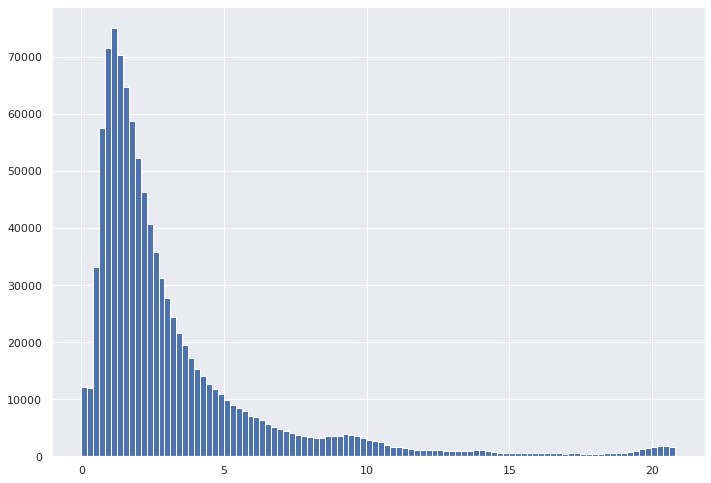

In [48]:
plt.hist(X_train['haversine'], bins=100, range=(0, np.percentile(X_train['haversine'], 99)))

Так же поступим для логарифма длины поездки

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.3000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7700e+02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.1800e+02, 0.0000e+00, 3.1700e+02,
        0.0000e+00, 0.0000e+00, 2.8400e+02, 1.9200e+02, 0.0000e+00,
        2.1800e+02, 2.0600e+02, 0.0000e+00, 2.3900e+02, 1.8200e+02,
        1.6400e+02, 1.5200e+02, 1.6200e+02, 1.7600e+02, 2.7400e+02,
        1.4900e+02, 2.7800e+02, 2.4900e+02, 1.2500e+02, 2.6200e+02,
        3.7900e+02, 2.4600e+02, 3.5900e+02, 2.5200e+02, 4.5300e+02,
        3.4000e+02, 3.5900e+02, 5.0000e+02, 6.4900e+02, 5.9800e+02,
        8.3200e+02, 1.0570e+03, 1.0480e+03, 1.6740e+03, 1.8890e+03,
        2.3310e+03, 2.9610e+03, 3.8340e+03, 4.9490e+03, 5.6060e+03,
        6.9900e+03, 8.6870e+03, 1.1705e+04, 1.3123e+04, 1.5171e+04,
        1.8516e+04, 2.2879e+04, 2.5193e+04, 2.8388e+04, 3.3926e+04,
        3.5911e+04, 3.9928e+04, 4.5360e+04, 4.90

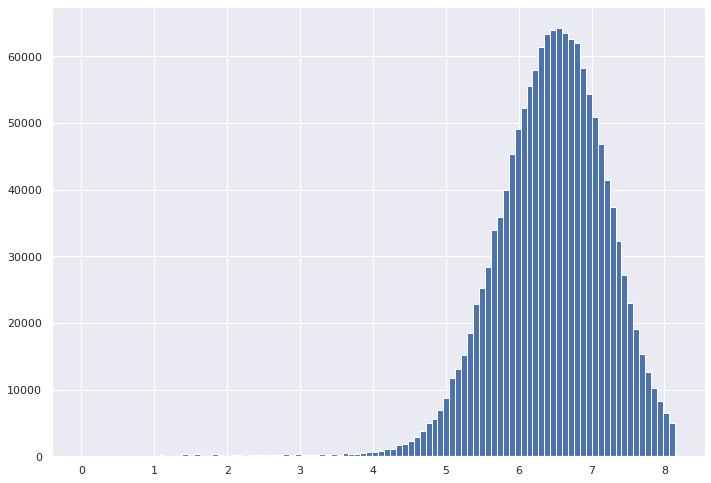

In [49]:
plt.hist(df['log_trip_duration'], bins = 100, range=(0, np.percentile(df.log_trip_duration, 99)))

Уберём выбросы из нашей выборки, ориентируясь на гистограммы распределения. 

In [50]:
df.drop(df[(df.haversine < 1) | (df.haversine > 20)].index, inplace = True)
df.drop(df[(df.log_trip_duration > 9) | (df.log_trip_duration < 1)].index, inplace = True)

У нас получается очень много категориальных признаков, причём в них могут содержаться редкие категории, что плохо, поскольку модель может сильно из-за этого переобучиться. Объединим редкие категории в одну.

In [51]:
df = mapTransformer.transform(df)

In [52]:
dropoff_sq = df.coordinates_square_num_dropoff.value_counts()
pickup_sq = df.coordinates_square_num_pickup.value_counts()
sq_pickup_to_del = pickup_sq[pickup_sq.values < 1000].index
sq_dropoff_to_del = dropoff_sq[dropoff_sq.values < 1000].index
df.coordinates_square_num_dropoff = df.coordinates_square_num_dropoff.apply(lambda x: -1 if x in sq_dropoff_to_del else x)
df.coordinates_square_num_pickup = df.coordinates_square_num_pickup.apply(lambda x: -1 if x in sq_pickup_to_del else x)

Обучим модель на очищенных данных

In [53]:
X = df.drop('log_trip_duration', axis = 1)
y = df.log_trip_duration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

print("Train RMSE:", mean_squared_error(y_train, y_train_pred, squared = False))
print("Test RMSE:", mean_squared_error(y_test, y_test_pred, squared = False))

Train RMSE: 0.37210788222313324
Test RMSE: 0.37432545667260286


Снова получили улучшение качества.

##Кросс-валидация и сравнение моделей##

Попробуем обучить не Rigde, а Lasso регрессию и проверим, какая из них даёт лучшие показатели качества.

In [54]:
from sklearn.linear_model import Lasso
model = Lasso()
pipe = make_pipeline(mapTransformer, dropTransformer, column_trans, model)
pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)
print("Train RMSE:", mean_squared_error(y_train, y_train_pred, squared = False))
print("Test RMSE:", mean_squared_error(y_test, y_test_pred, squared = False))

Train RMSE: 0.6078225538168263
Test RMSE: 0.6094705565938312


Как мы можем видеть, использование Lasso регрессии приводит к ухудшению показателей метрики качества.

Разобьём обучающую выборку на обучающую и валидационную в отношении 8:2 и подберём по валидационной оптимальные значения параметра регуляризации для Ridge и Lasso. Затем на тестовой выборке измерим качество лучшей полученной модели.

In [55]:
from sklearn.model_selection import GridSearchCV
alphas = np.logspace(-3, 2, 20)
params = {'alpha': alphas}
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 10)
grid_search_ridge = GridSearchCV(Ridge(), params, cv = 10, scoring = 'neg_root_mean_squared_error')
pipe = make_pipeline(mapTransformer, dropTransformer, column_trans, grid_search_ridge)
pipe.fit(X_val, y_val)
ridge_best_alpha =  grid_search_ridge.best_params_
ridge_best_alpha

{'alpha': 29.763514416313193}

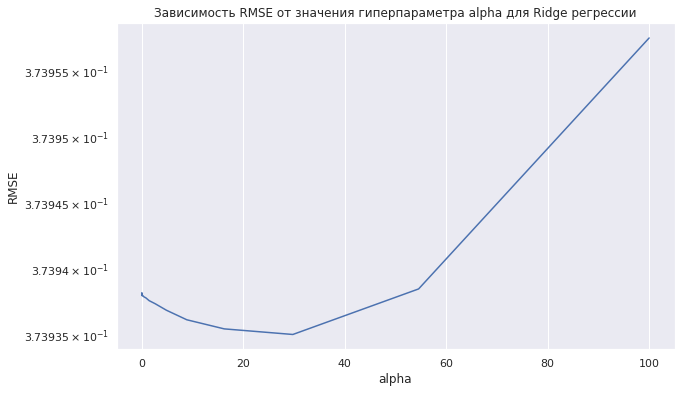

In [56]:
plt.figure(figsize=(10,6))
plot = plt.plot(alphas, -grid_search_ridge.cv_results_['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('Зависимость RMSE от значения гиперпараметра alpha для Ridge регрессии')
plt.yscale('log')

In [57]:
grid_search_lasso = GridSearchCV(Lasso(), params, cv = 10, scoring = 'neg_root_mean_squared_error')
pipe = make_pipeline(mapTransformer, dropTransformer, column_trans, grid_search_lasso)
pipe.fit(X_val, y_val)
lasso_best_alpha =  grid_search_lasso.best_params_
lasso_best_alpha

{'alpha': 0.001}

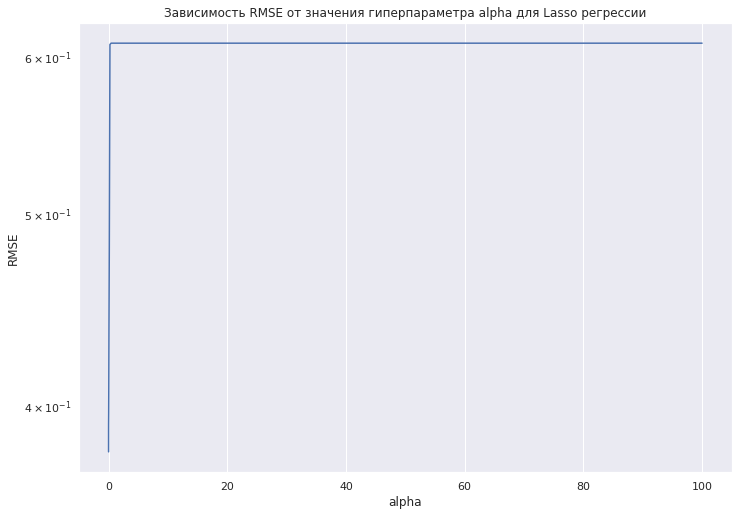

In [58]:
plot = plt.plot(alphas, -grid_search_lasso.cv_results_['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('Зависимость RMSE от значения гиперпараметра alpha для Lasso регрессии')
plt.yscale('log')

Можем заметить, что ошибка быстро возрастает при увеличении параметра. Попробуем сдвинуть правую границу влево и построить новый график.

In [59]:
alphas = np.logspace(-3, -1, 20)

In [60]:
pipe.fit(X_val, y_val)
lasso_best_alpha =  grid_search_lasso.best_params_
lasso_best_alpha

{'alpha': 0.001}

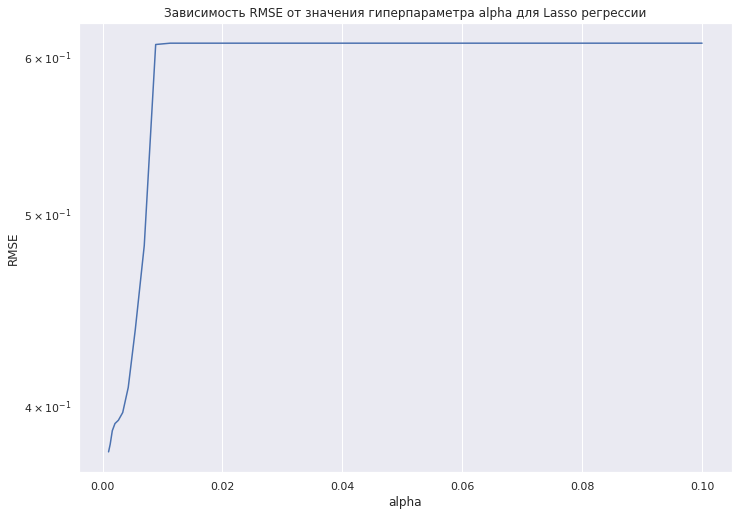

In [61]:
plot = plt.plot(alphas, -grid_search_lasso.cv_results_['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('Зависимость RMSE от значения гиперпараметра alpha для Lasso регрессии')
plt.yscale('log')

Обучим две новые модели, используя значения гиперпараметров, полученные в результате кросс-валидации.

**Lasso регрессия**

In [62]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 10)
model = Lasso(alpha = lasso_best_alpha['alpha'])
pipe = make_pipeline(mapTransformer, dropTransformer, column_trans, model)
pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)
print("Train RMSE:", mean_squared_error(y_train, y_train_pred, squared = False))
print("Test RMSE:", mean_squared_error(y_test, y_test_pred, squared = False))

Train RMSE: 0.3775903289781772
Test RMSE: 0.37925962097747934


**Ridge регрессия**

In [63]:
model = Ridge(alpha = ridge_best_alpha['alpha'])
pipe = make_pipeline(mapTransformer, dropTransformer, column_trans, model)
pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)
print("Train RMSE:", mean_squared_error(y_train, y_train_pred, squared = False))
print("Test RMSE:", mean_squared_error(y_test, y_test_pred, squared = False))

Train RMSE: 0.3725067008133274
Test RMSE: 0.37429500598511045


Для Lasso получили значительное улучшение значения метрики качества, при это заметитим, что Ridge всё ещё превосходит Lasso по показателям.